# Import Library

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Scraping

In [2]:
# List ticker untuk saham 10 perusahaan Indonesia
tickers = ['BBCA.JK', 'BYAN.JK', 'TPIA.JK', 'BBRI.JK', 'BMRI.JK', 'DSSA.JK', 'TLKM.JK', 'ASII.JK', 'BBNI.JK', 'ICBP.JK']

# Download data harga penutupan (adjusted close) untuk setiap perusahaan dengan interval 1 hari
stock_close_datas = {}
stock_open_datas = {}
stock_high_datas = {}
stock_low_datas = {}
stock_volume_datas = {}
for ticker in tickers:
  df = yf.download(ticker, start='2018-01-01', end='2025-05-15', interval='1d')
  stock_open_datas[ticker] = df['Open']
  stock_high_datas[ticker] = df['High']
  stock_low_datas[ticker] = df['Low']
  stock_volume_datas[ticker] = df['Volume']
  stock_close_datas[ticker] = df['Close']

# Gabung semua jadi 1 dataframe
df_all = pd.concat(stock_close_datas, axis=1)
df_all.columns = tickers

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_all

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926025,716.898010,1457.917603,2289.993164,2592.609863,1390.0,3339.208496,5383.927734,3732.604004,7525.144043
2018-01-02,3723.926025,723.661194,1439.693604,2283.701904,2543.998779,1410.0,3316.646240,5319.062012,3685.474854,7694.249023
2018-01-03,3723.926025,723.661194,1403.245728,2271.119141,2495.387207,1390.0,3181.273438,5221.761719,3553.514404,7694.249023
2018-01-04,3779.189697,716.898010,1348.573853,2233.372070,2535.896729,1390.0,3173.752197,5335.278320,3544.088135,7715.386230
2018-01-05,3783.440918,720.279480,1385.021851,2258.536865,2535.896729,1390.0,3218.876465,5383.927734,3506.385254,7842.213867
...,...,...,...,...,...,...,...,...,...,...
2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4448.971191,4180.000000,11275.000000
2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4523.901367,4160.000000,11075.000000
2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4477.070312,4120.000000,11400.000000


# Data Preprocessing

## Menangani Missing Value

In [4]:
df_all.isnull().sum()

,0
BBCA.JK,0
BYAN.JK,0
TPIA.JK,0
BBRI.JK,0
BMRI.JK,0
DSSA.JK,0
TLKM.JK,1
ASII.JK,1
BBNI.JK,0
ICBP.JK,1


In [5]:
# Melihat baris yang bernilai null
df_all[df_all.isnull().any(axis=1)]

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2019-06-19,5152.053223,1153.150757,1209.519653,2880.276123,2881.31665,1450.0,NaN,NaN,3534.166504,NaN


In [13]:
df_all_ffil = df_all.ffill()
display(df_all_ffil.loc["2019-06-18"])
display(df_all_ffil.loc["2019-06-19"])

,2019-06-18
BBCA.JK,5117.358398
BYAN.JK,1160.312988
TPIA.JK,1202.114380
BBRI.JK,2860.134521
BMRI.JK,2836.155029
DSSA.JK,1450.000000
TLKM.JK,3145.500977
ASII.JK,5101.784668
BBNI.JK,3464.674561
ICBP.JK,9077.743164


,2019-06-19
BBCA.JK,5152.053223
BYAN.JK,1153.150757
TPIA.JK,1209.519653
BBRI.JK,2880.276123
BMRI.JK,2881.316650
DSSA.JK,1450.000000
TLKM.JK,3145.500977
ASII.JK,5101.784668
BBNI.JK,3534.166504
ICBP.JK,9077.743164


In [14]:
df_all_ffil.shape

(1811, 10)

## Mengganti Nama Kolom

In [15]:
df_all_ffil.columns = df_all_ffil.columns.str.replace('.JK', '', regex=False)
df_all_ffil

,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
Date,,,,,,,,,,
2018-01-01,3723.926025,716.898010,1457.917603,2289.993164,2592.609863,1390.0,3339.208496,5383.927734,3732.604004,7525.144043
2018-01-02,3723.926025,723.661194,1439.693604,2283.701904,2543.998779,1410.0,3316.646240,5319.062012,3685.474854,7694.249023
2018-01-03,3723.926025,723.661194,1403.245728,2271.119141,2495.387207,1390.0,3181.273438,5221.761719,3553.514404,7694.249023
2018-01-04,3779.189697,716.898010,1348.573853,2233.372070,2535.896729,1390.0,3173.752197,5335.278320,3544.088135,7715.386230
2018-01-05,3783.440918,720.279480,1385.021851,2258.536865,2535.896729,1390.0,3218.876465,5383.927734,3506.385254,7842.213867
...,...,...,...,...,...,...,...,...,...,...
2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4448.971191,4180.000000,11275.000000
2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4523.901367,4160.000000,11075.000000
2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4477.070312,4120.000000,11400.000000


## Menambah Fitur Tanggal

Dilakukan pengubahan data tanggal dari index menjadi kolom date

In [16]:
df_all_ffil = df_all_ffil.reset_index()
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926025,716.898010,1457.917603,2289.993164,2592.609863,1390.0,3339.208496,5383.927734,3732.604004,7525.144043
1,2018-01-02,3723.926025,723.661194,1439.693604,2283.701904,2543.998779,1410.0,3316.646240,5319.062012,3685.474854,7694.249023
2,2018-01-03,3723.926025,723.661194,1403.245728,2271.119141,2495.387207,1390.0,3181.273438,5221.761719,3553.514404,7694.249023
3,2018-01-04,3779.189697,716.898010,1348.573853,2233.372070,2535.896729,1390.0,3173.752197,5335.278320,3544.088135,7715.386230
4,2018-01-05,3783.440918,720.279480,1385.021851,2258.536865,2535.896729,1390.0,3218.876465,5383.927734,3506.385254,7842.213867
...,...,...,...,...,...,...,...,...,...,...,...
1806,2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4448.971191,4180.000000,11275.000000
1807,2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4523.901367,4160.000000,11075.000000
1808,2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4477.070312,4120.000000,11400.000000
1809,2025-05-09,9000.000000,20200.000000,8525.000000,3840.000000,4770.000000,49325.0,2600.000000,4477.070312,4100.000000,11200.000000


## Menangani Duplikasi Data

In [17]:
print("Jumlah duplikasi data:", df_all_ffil.duplicated().sum())

Jumlah duplikasi data: 0


## Mengurutkan data

Karena data yang dibutuhkan merupakan data time series, maka datanya harus berurutan berdasarkan waktu (Kolom `Date`)

In [18]:
df_all_ffil = df_all_ffil.sort_values(by="Date", ascending=True)
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926025,716.898010,1457.917603,2289.993164,2592.609863,1390.0,3339.208496,5383.927734,3732.604004,7525.144043
1,2018-01-02,3723.926025,723.661194,1439.693604,2283.701904,2543.998779,1410.0,3316.646240,5319.062012,3685.474854,7694.249023
2,2018-01-03,3723.926025,723.661194,1403.245728,2271.119141,2495.387207,1390.0,3181.273438,5221.761719,3553.514404,7694.249023
3,2018-01-04,3779.189697,716.898010,1348.573853,2233.372070,2535.896729,1390.0,3173.752197,5335.278320,3544.088135,7715.386230
4,2018-01-05,3783.440918,720.279480,1385.021851,2258.536865,2535.896729,1390.0,3218.876465,5383.927734,3506.385254,7842.213867
...,...,...,...,...,...,...,...,...,...,...,...
1806,2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4448.971191,4180.000000,11275.000000
1807,2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4523.901367,4160.000000,11075.000000
1808,2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4477.070312,4120.000000,11400.000000
1809,2025-05-09,9000.000000,20200.000000,8525.000000,3840.000000,4770.000000,49325.0,2600.000000,4477.070312,4100.000000,11200.000000


# Data Exploration

## Deskripsi Variabel

Setiap kolom berisi harga saham penutupan (adjusted close) dari top 20 emiten Indonesia

In [19]:
df_all_ffil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1811 non-null   datetime64[ns]
 1   BBCA    1811 non-null   float64       
 2   BYAN    1811 non-null   float64       
 3   TPIA    1811 non-null   float64       
 4   BBRI    1811 non-null   float64       
 5   BMRI    1811 non-null   float64       
 6   DSSA    1811 non-null   float64       
 7   TLKM    1810 non-null   float64       
 8   ASII    1810 non-null   float64       
 9   BBNI    1811 non-null   float64       
 10  ICBP    1810 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 155.8 KB


Terdapat nilai null pada beberapa kolom

In [20]:
df_all_ffil.describe()

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
count,1811,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1810.000000,1810.000000,1811.000000,1810.000000
mean,2021-08-10 03:20:22.528989440,6575.199872,7214.450629,2981.308596,3292.208066,3455.223680,7405.251242,3133.835382,4525.491051,3368.738708,9228.747414
min,2018-01-01 00:00:00,3529.552734,591.778931,1093.920898,1513.757080,1411.887085,920.000000,2070.656006,2251.151611,1292.781372,6683.181152
25%,2019-09-25 12:00:00,5048.833740,1164.566528,1682.525757,2512.330811,2476.076172,1472.500000,2790.936279,4186.592285,2797.437256,8024.523926
50%,2021-08-05 00:00:00,6037.152832,1421.741699,2229.064453,3194.934326,2795.157715,2125.000000,3040.405029,4570.260986,3402.971436,9091.309570
75%,2023-06-13 12:00:00,8330.894043,17346.111328,2561.516479,3961.752930,4429.971680,4900.000000,3522.970825,4913.387817,3967.651367,10371.634766
max,2025-05-14 00:00:00,10570.414062,22548.173828,10625.000000,5763.100098,6769.004883,49900.000000,4295.701172,5738.722656,5460.848145,12800.000000
std,NaN,1891.525139,7880.024217,2298.569433,928.953145,1333.204630,11880.027645,463.457790,631.170352,887.597171,1388.437083


## Analisis Harga Saham Tiap Perusahaan

In [21]:
dates = df_all_ffil['Date']
stocks = df_all_ffil.drop(columns='Date')

<Figure size 1400x600 with 0 Axes>

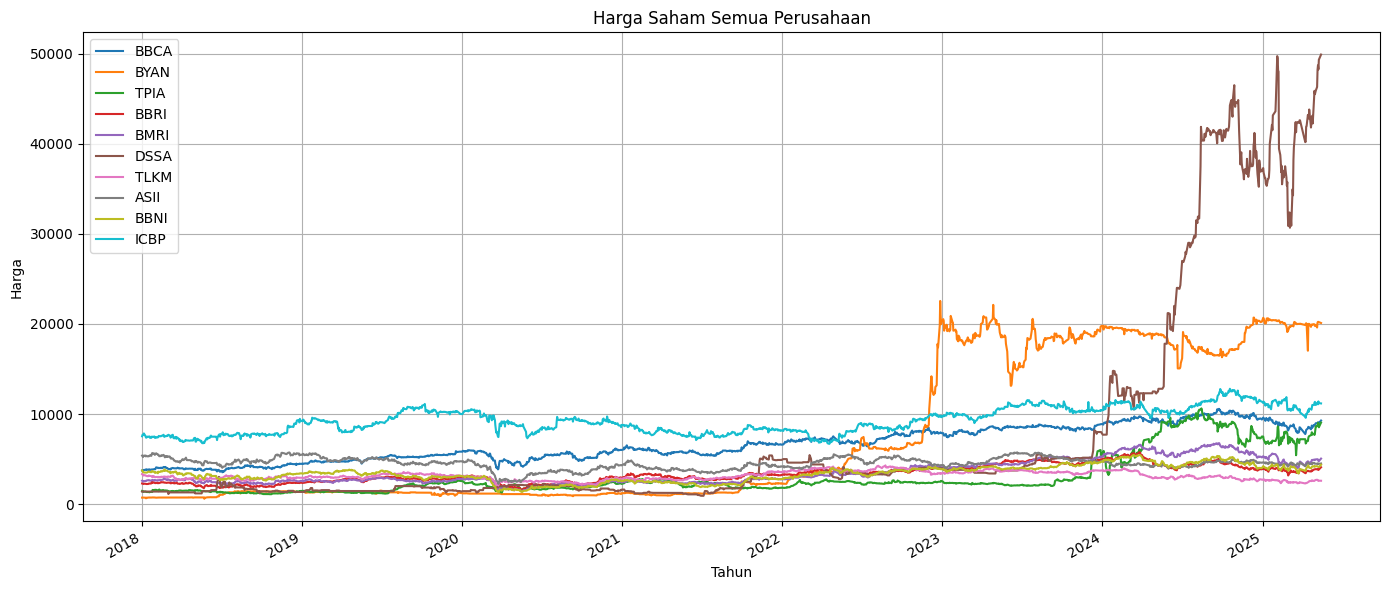

In [22]:
plt.figure(figsize=(14, 6))
stocks.index = dates  # ubah dates jadi index
stocks.plot(figsize=(14, 6))
plt.ylabel("Harga")
plt.xlabel("Tahun")
plt.title("Harga Saham Semua Perusahaan")
plt.grid(True)
plt.tight_layout()
plt.show()

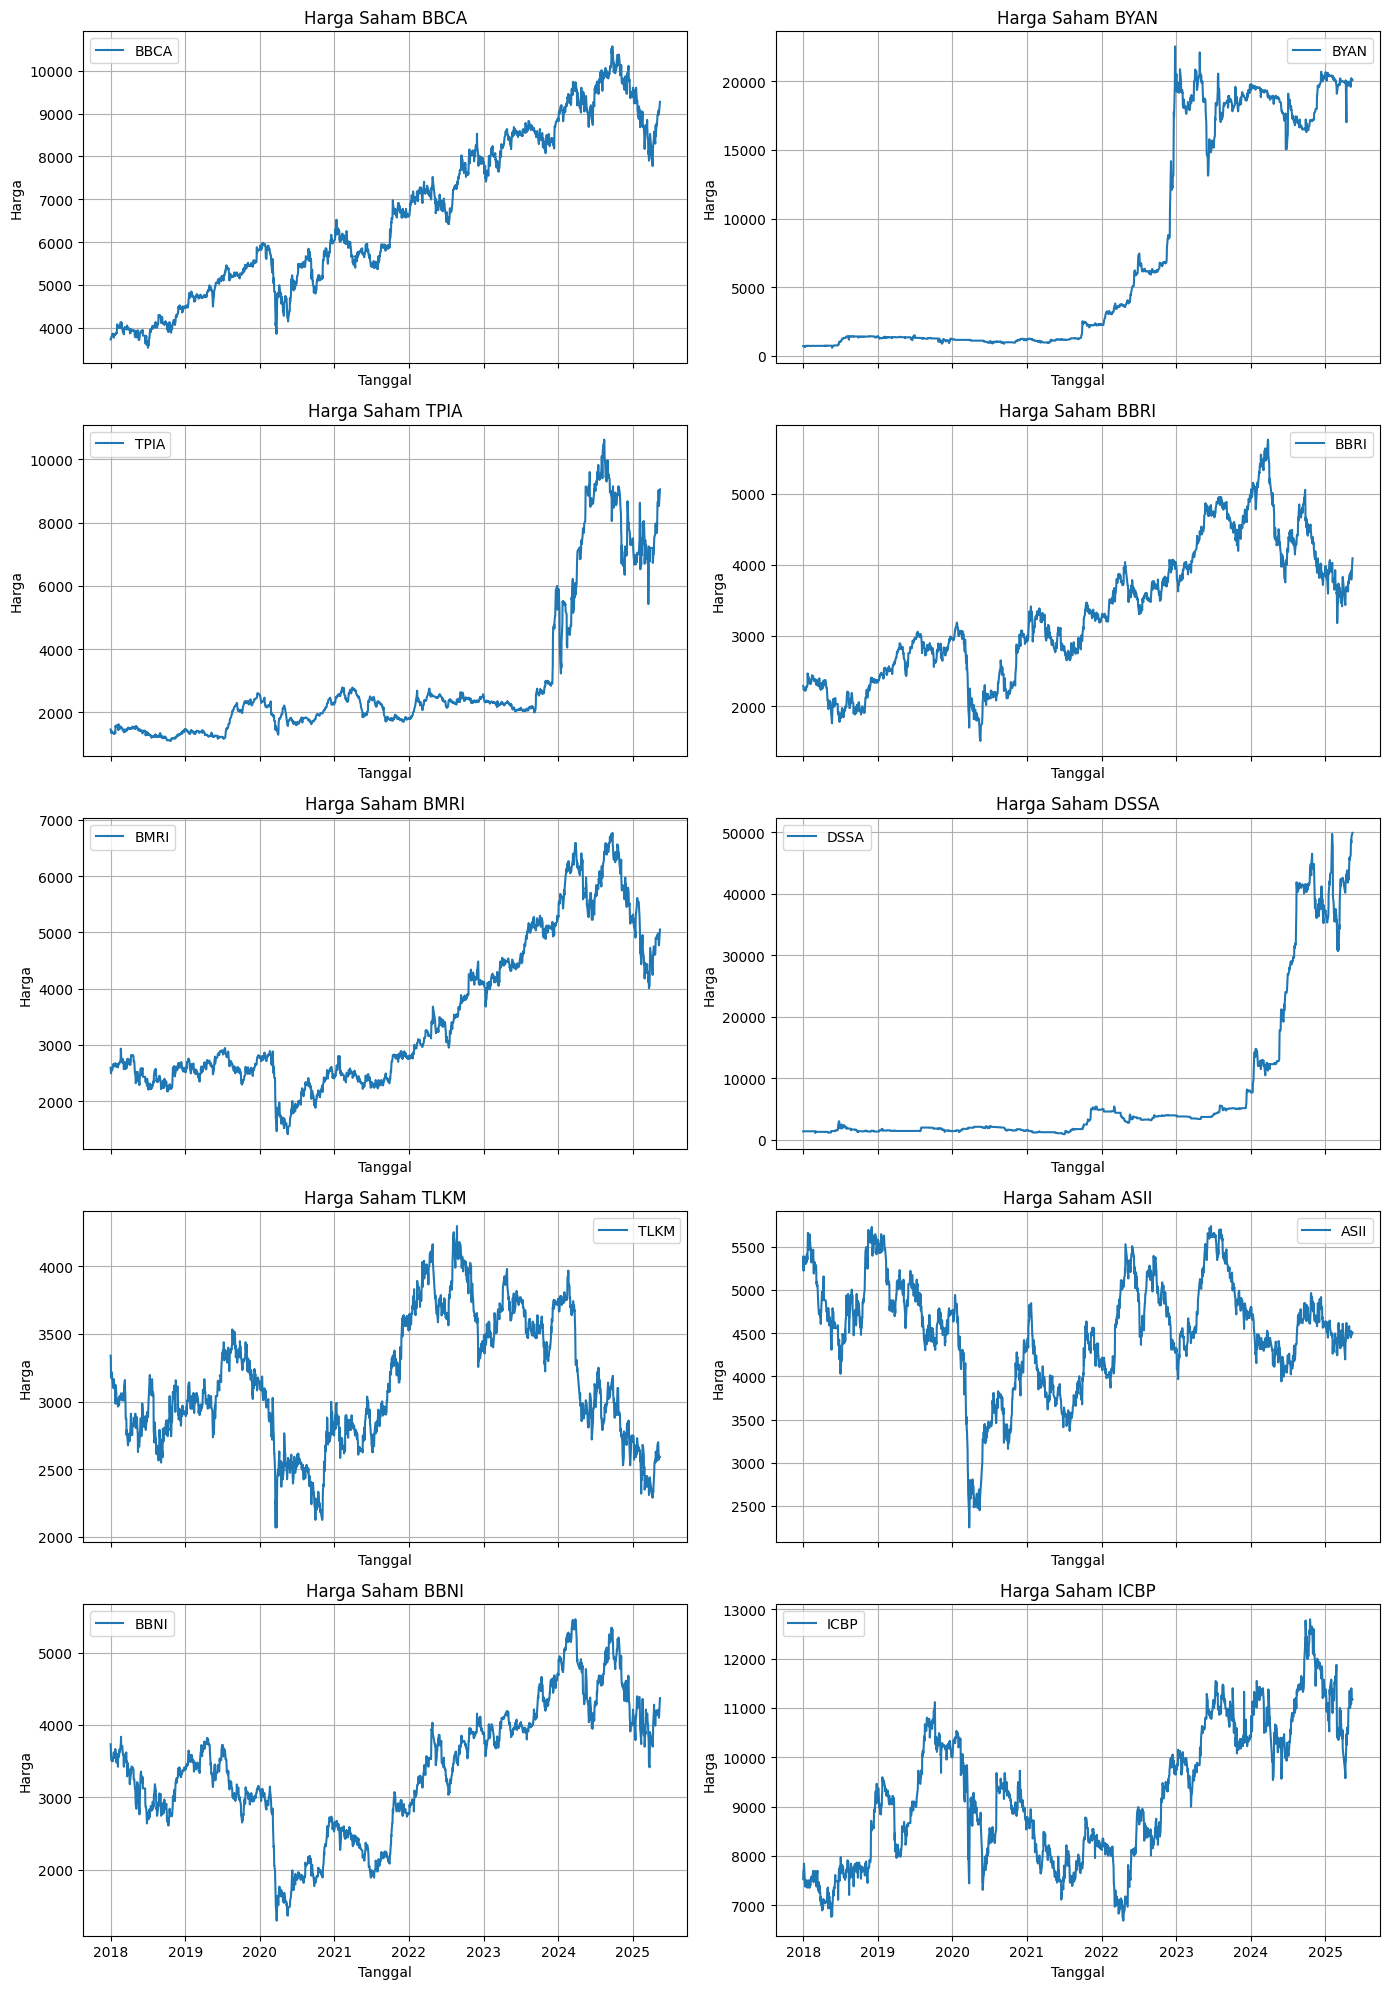

In [23]:
num_stocks = len(stocks.columns)
cols = 2  # jumlah kolom subplot
rows = (num_stocks + cols - 1) // cols  # jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()  # ubah axes jadi array datar agar mudah diakses

for i, stock in enumerate(stocks.columns):
    axes[i].plot(dates, stocks[stock], label=stock)
    axes[i].set_title(f"Harga Saham {stock}")
    axes[i].set_ylabel("Harga")
    axes[i].set_xlabel("Tanggal")
    axes[i].legend()
    axes[i].grid(True)

# Sembunyikan subplot kosong jika jumlah saham ganjil
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Korelasi Antar Saham

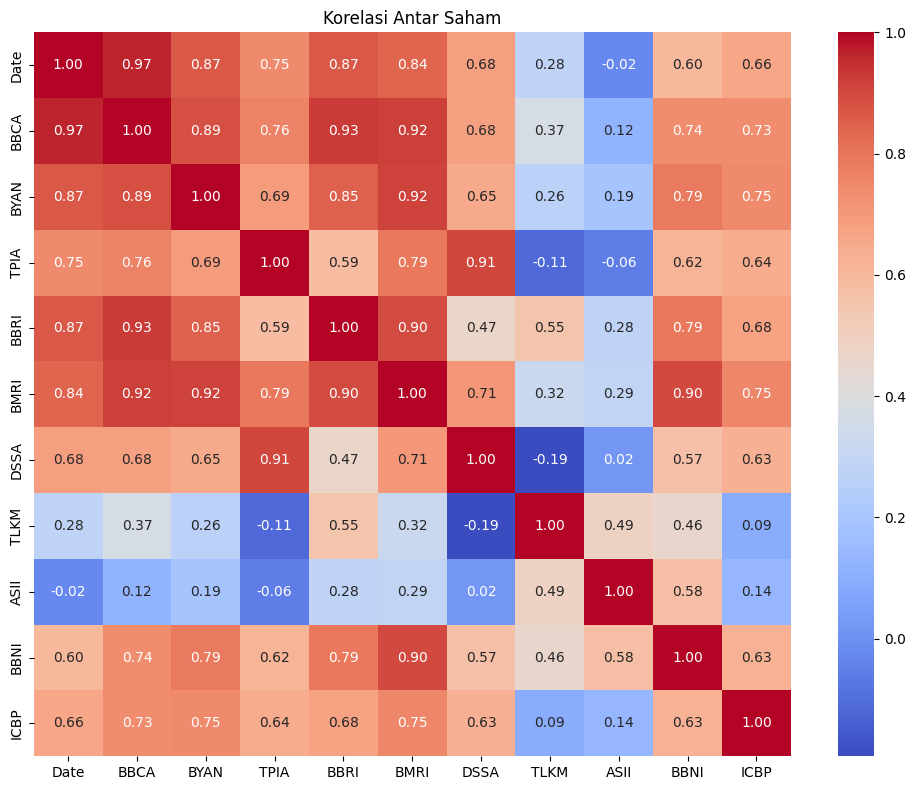

In [24]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_all_ffil.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Saham")
plt.tight_layout()
plt.show()

# Data Preparation

## Simpan Data ke Format CSV

In [25]:
# Saving data to csv
df_all_ffil.to_csv("stocks.csv", index=False)

## Normalisasi Data

# Modeling